[191 166  50]


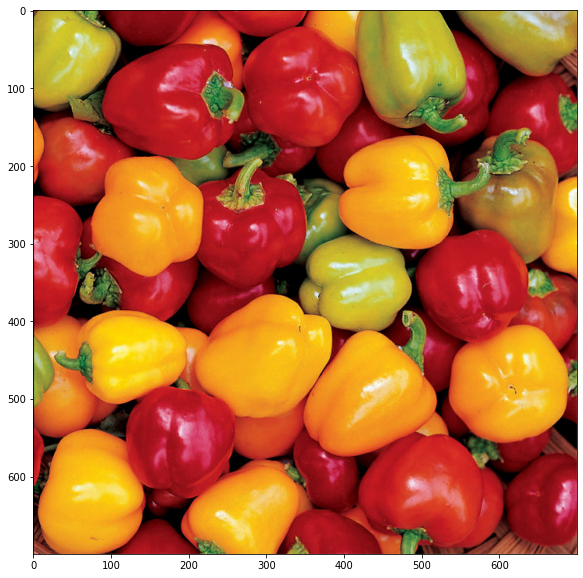

In [18]:
from skimage.io import imread, imsave
import numpy as np
import matplotlib.pyplot as plt

image = imread('peppers.jpg')
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
print(image[10, 10, :])
ax.imshow(image)
#image = image / 255


In [19]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=8, random_state=0).fit(image.reshape(-1, 3))

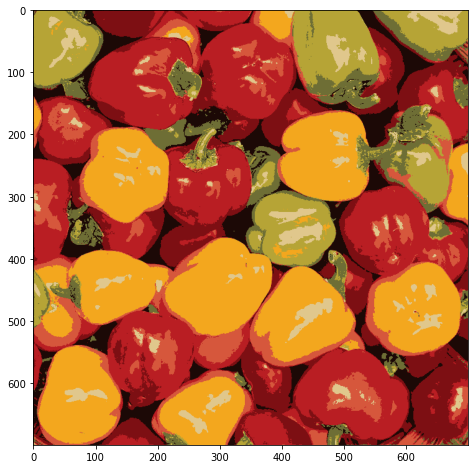

In [58]:
from skimage.io import imsave

clusters = kmeans.cluster_centers_.astype(np.uint8)
clusters = clusters[np.newaxis, np.newaxis, ...]
clusters = np.tile(clusters, [image.shape[0], image.shape[0], 1, 1]).reshape(-1, 8, 3)
indices = kmeans.labels_[:, np.newaxis, np.newaxis]
quantized_image = np.take_along_axis(clusters, indices, axis=1).reshape(image.shape)
fig, ax = plt.subplots(1, 1, figsize=(8,8))
ax.imshow(quantized_image)
imsave('quantized_peppers.jpg', quantized_image)

#quantized_image = np.take_along_axis(cluster_image, kmeans.labels_, axis=-1)
#unique, counts = np.unique(kmeans.labels_, return_counts=True)
#np.savetxt('colors.txt', kmeans.cluster_centers_, fmt='%1.3f')
#np.savetxt('distributions.txt', counts / image[..., 0].size, fmt='%1.3f')

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


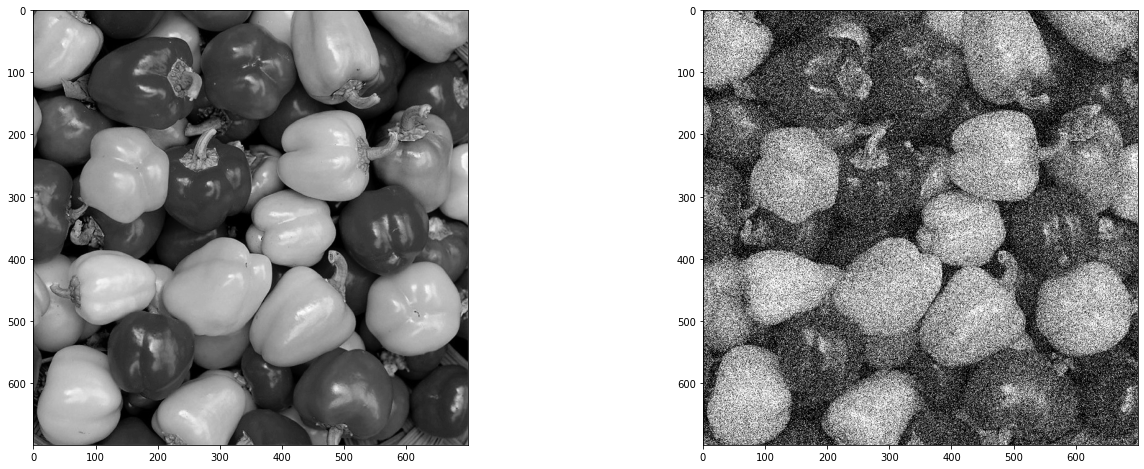

In [17]:
from skimage.color import rgb2gray
from skimage.io import imsave

image_gray = rgb2gray(image)
noisy_img = image_gray + np.random.normal(0, 0.3, image_gray.shape)
noisy_img_clipped = np.clip(noisy_img, 0, 1)
imsave('noisy_peppers.jpg', noisy_img_clipped)
fig, ax = plt.subplots(1, 2, figsize=(22, 8))
ax[0].imshow(image_gray, cmap='gray')
ax[1].imshow(noisy_img_clipped, cmap='gray')

In [74]:
from numpy.linalg import norm

def get_ratio(candidate, x, y, i, j):
    regularizer = norm(x[i, j] - x[i - 1, j]) + norm(x[i, j] - x[i + 1, j]) + norm(x[i, j] - x[i, j - 1]) + norm(x[i, j] - x[i, j + 1])
    data_consistency = norm(x[i, j] - y[i, j])
    u_denominator = 1 * data_consistency + 0 * regularizer

    regularizer = norm(candidate - x[i - 1, j]) + norm(candidate - x[i + 1, j]) + norm(candidate - x[i, j - 1]) + norm(candidate - x[i, j + 1])
    data_consistency = norm(candidate - y[i, j])
    u_numerator = 1 * data_consistency + 0 * regularizer

    #return np.exp(-u_numerator) / np.exp(-u_denominator)
    return u_denominator - u_numerator

In [75]:
def update_temp(r):
    return np.power(0.99, np.exp(8 * r))

1002517


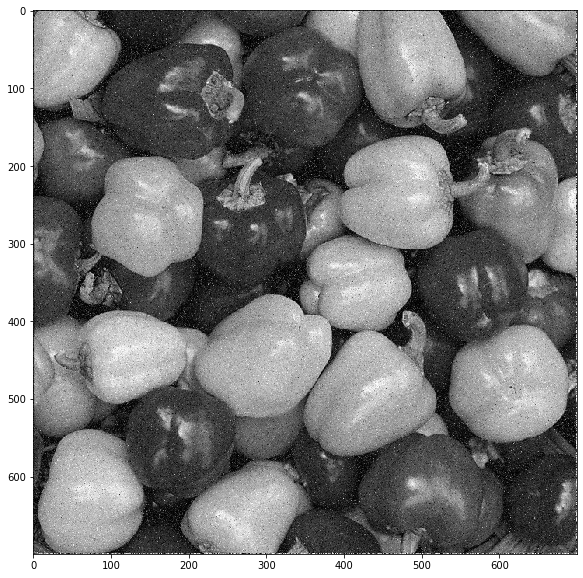

In [76]:
from numpy.random import rand, randint

h = image.shape[0]
w = image.shape[1]
x = rand(h, w)
y = image
T = 4
count = 0
iterations = 10000000

for iter in range(iterations):
    row = randint(1, h - 1)
    col = randint(1, w - 1)
    candidate = rand()
    value = get_ratio(candidate, x, y, row, col)
    #p = min(1, value)
    p = np.exp(min(0, value) / T)
    if rand() < p:
        count += 1
        x[row, col] = candidate
    T *= update_temp(iter / iterations)

print(count)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(x, cmap='gray')